In [1]:
import findspark
findspark.init()
findspark.find()


'/home/glue_user/spark'

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F,Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType,DateType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:

# Create a SparkConf object
conf = SparkConf().setAppName("MyApp")

conf.set("spark.executor.memory", "16g")
conf.set("spark.driver.memory", "8g")
conf.set("spark.master", "local[4]")
conf.set("spark.executor.instances", "4")
conf.set('spark.executor.cores', '8')
#conf.set('spark.driver.maxResultSize', '4g')
#conf.set("spark.local.dir", "/mnt/ssd/spark")

#creating spark context 
sc = SparkContext(conf=conf)

#creating a spark session
spark = SparkSession.builder.getOrCreate()

In [4]:
# Define the fields of the schema
fields = [StructField("marketplace", StringType(), True),
          StructField("customer_id", StringType(), True),
          StructField("review_id", StringType(), True),
          StructField("product_id", StringType(), True),
          StructField("product_parent", StringType(), True),
          StructField("product_title", StringType(), True),
          StructField("star_rating", IntegerType(), True),
          StructField("helpful_votes", IntegerType(), True),
          StructField("total_votes", IntegerType(), True),
          StructField("vine", StringType(), True),
          StructField("verified_purchase", StringType(), True),
          StructField("review_headline", StringType(), True),
          StructField("review_body", StringType(), True),
          StructField("review_date", DateType(), True),
          StructField("year", IntegerType(), True)]

#creating a schema for atframes
schema = StructType(fields)

#reading books review data 
df_books = spark.read.schema(schema).parquet("s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet")

#creating a constant column with product category == Music
df_books =  df_books.withColumn('productCategory',F.lit("Books"))

#caching book dataframe
df_books.cache()


#reading music reviews data 
df_music = spark.read.schema(schema).parquet("s3://amazon-reviews-pds/parquet/product_category=Music/*.parquet")

#creating a constant column with product category == Music
df_music =  df_music.withColumn('productCategory',F.lit("Music"))

#caching music data
df_music.cache()





DataFrame[marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: date, year: int, productCategory: string]

In [5]:
# creating a unionised dataframe for EDA
df_music_books = df_books.union(df_music)

In [6]:
#caching unionised dataframe
df_music_books.cache()

DataFrame[marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: date, year: int, productCategory: string]

#### At this stage, we have a unified dataframe containing all the books and music products reviews with additional dimension i.e. productCategory

In [7]:
df_music_books.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+---------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|productCategory|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+---------------+
|         US|   15444933|R1WWG70WK9VUCH|1848192576|     835940987|Standing Qigong f...|          5|            9|         10|   N|                Y|Informative AND i...|After attending a...| 2015-05-02|2015|          Books|
|         US|   20595117|R1EQ3POS0RIOD5|145162445X|     574044348|A Universe from N...|          4|     

## Exploratory Data Analysis

#### 1. Getting  reviews (%) for each category

In [9]:
df_num_reviews = df_music_books.groupby('productCategory').agg(F.count('review_id'))

In [12]:
df_num_reviews.show()

+---------------+----------------+
|productCategory|count(review_id)|
+---------------+----------------+
|          Books|        20726160|
|          Music|         6177781|
+---------------+----------------+



In [25]:
#calculating total reviews
total_reviews = df_num_reviews.agg(F.sum('count(review_id)')).first()[0]

In [28]:
df_num_reviews_perc =  df_num_reviews.withColumn('reviews_percent', F.col('count(review_id)')/total_reviews*100)

In [29]:
df_num_reviews_perc.show()

+---------------+----------------+------------------+
|productCategory|count(review_id)|   reviews_percent|
+---------------+----------------+------------------+
|          Books|        20726160| 77.03763548990834|
|          Music|         6177781|22.962364510091664|
+---------------+----------------+------------------+



In [30]:
pd_num_reviews_perc = df_num_reviews_perc.toPandas()

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

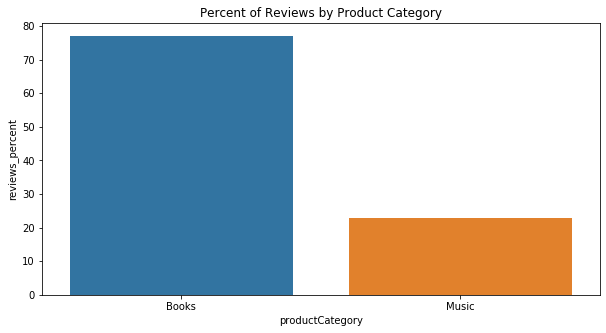

In [45]:
# Create a figure with a specified size
plt.figure(figsize=(10, 5))
# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Percentage of Total')
plt.title('Percent of Reviews by Product Category')
sns.barplot(data=pd_num_reviews_perc, x="productCategory", y="reviews_percent")

As observed 77% of reviews in the dataset are for book products

#### 2. Getting  reviews (%) by star rating and product category

In [40]:
df_num_reviews_rating =  df_music_books.groupby('productCategory', 'star_rating').agg(F.count('review_id'))

In [48]:
df_num_reviews_rating_perc = df_num_reviews_rating.withColumn('reviews_perc', F.col('count(review_id)')/F.sum('count(review_id)').over(Window.partitionBy('productCategory'))*100).sort([ 'productCategory', 'star_rating'], ascending=[True, True])

In [49]:
df_num_reviews_rating_perc.show()

+---------------+-----------+----------------+------------------+
|productCategory|star_rating|count(review_id)|      reviews_perc|
+---------------+-----------+----------------+------------------+
|          Books|          1|         1112232| 5.366319665582047|
|          Books|          2|          861867|  4.15835350108269|
|          Books|          3|         1543611| 7.447645873620584|
|          Books|          4|         3546319|17.110352327686364|
|          Books|          5|        13662131| 65.91732863202832|
|          Music|          1|          254396| 4.117918715474051|
|          Music|          2|          202861| 3.283719510290183|
|          Music|          3|          405541| 6.564509165993421|
|          Music|          4|         1018968|16.494077727909097|
|          Music|          5|         4296015| 69.53977488033325|
+---------------+-----------+----------------+------------------+



In [50]:
pd_num_reviews_rating_perc = df_num_reviews_rating_perc.toPandas()

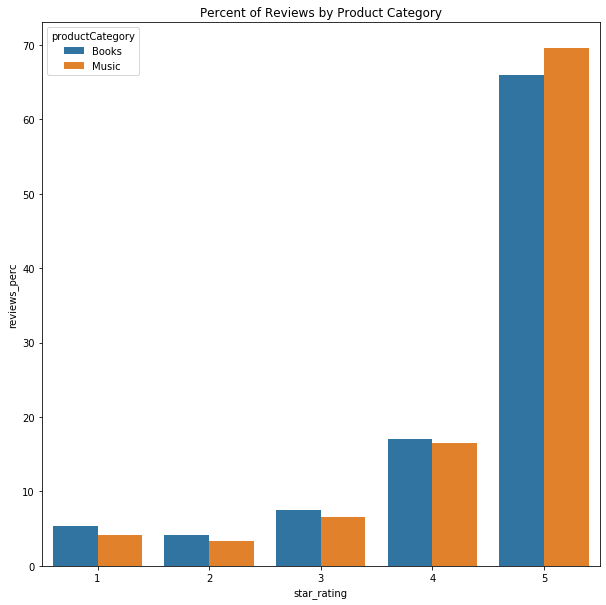

In [52]:
# Create a figure with a specified size
plt.figure(figsize=(10, 10))
# Add labels and title
plt.xlabel('Star Rating')
plt.ylabel('Percentage of Total')
plt.title('Percent of Reviews by Product Category')
sns.barplot(data=pd_num_reviews_rating_perc, x="star_rating", y="reviews_perc", hue ='productCategory')

A majority of reviews are rated 5 in both the product categories with music products having a slightly higher proprotion og 5-star reviews.

#### 3.Ratings by Market PLace


In [78]:
df_reviews_by_marketplace = df_music_books.groupby(['marketplace', 'productCategory', 'star_rating']).agg(F.count('review_id')).sort(['marketplace', 'productCategory', 'star_rating'], ascending=[True, True, False])


In [79]:
df_reviews_by_marketplace.cache()

DataFrame[marketplace: string, productCategory: string, star_rating: int, count(review_id): bigint]

In [80]:
df_reviews_by_marketplace.show()

+-----------+---------------+-----------+----------------+
|marketplace|productCategory|star_rating|count(review_id)|
+-----------+---------------+-----------+----------------+
|         DE|          Books|          5|           43205|
|         DE|          Books|          4|            9923|
|         DE|          Books|          3|            4540|
|         DE|          Books|          2|            2833|
|         DE|          Books|          1|            3359|
|         DE|          Music|          5|          113119|
|         DE|          Music|          4|           22613|
|         DE|          Music|          3|           11270|
|         DE|          Music|          2|            6692|
|         DE|          Music|          1|            6905|
|         FR|          Books|          5|           13452|
|         FR|          Books|          4|            4147|
|         FR|          Books|          3|            1875|
|         FR|          Books|          2|            100

##### Since majority reviews are 5-star rated, comparing out of all 5-star ratings which market place contributes to most 5-star ratings in each category.

In [81]:
#filtering 5-star rating data
df_reviews_by_marketplace_5 = df_reviews_by_marketplace.filter(F.col('star_rating')==5)

In [82]:
df_reviews_by_marketplace_5.show()

+-----------+---------------+-----------+----------------+
|marketplace|productCategory|star_rating|count(review_id)|
+-----------+---------------+-----------+----------------+
|         DE|          Books|          5|           43205|
|         DE|          Music|          5|          113119|
|         FR|          Books|          5|           13452|
|         FR|          Music|          5|           47224|
|         JP|          Books|          5|            8150|
|         JP|          Music|          5|           57491|
|         UK|          Books|          5|          173046|
|         UK|          Music|          5|          242596|
|         US|          Books|          5|        13424278|
|         US|          Music|          5|         3835585|
+-----------+---------------+-----------+----------------+



In [86]:
df_reviews_by_marketplace_5 = df_reviews_by_marketplace_5.withColumn('percent',  F.col('count(review_id)')/F.sum('count(review_id)').over(Window.partitionBy('productCategory'))*100).sort(['productCategory', 'percent'], ascending =[True, False])

In [87]:
df_reviews_by_marketplace_5.show()

+-----------+---------------+-----------+----------------+-------------------+
|marketplace|productCategory|star_rating|count(review_id)|            percent|
+-----------+---------------+-----------+----------------+-------------------+
|         US|          Books|          5|        13424278|  98.25903440685791|
|         UK|          Books|          5|          173046| 1.2666106041583116|
|         DE|          Books|          5|           43205| 0.3162390991566396|
|         FR|          Books|          5|           13452|0.09846194565108474|
|         JP|          Books|          5|            8150|0.05965394417605862|
|         US|          Music|          5|         3835585|  89.28239310151385|
|         UK|          Music|          5|          242596|  5.647000766989873|
|         DE|          Music|          5|          113119| 2.6331146422905882|
|         JP|          Music|          5|           57491| 1.3382402063307506|
|         FR|          Music|          5|           

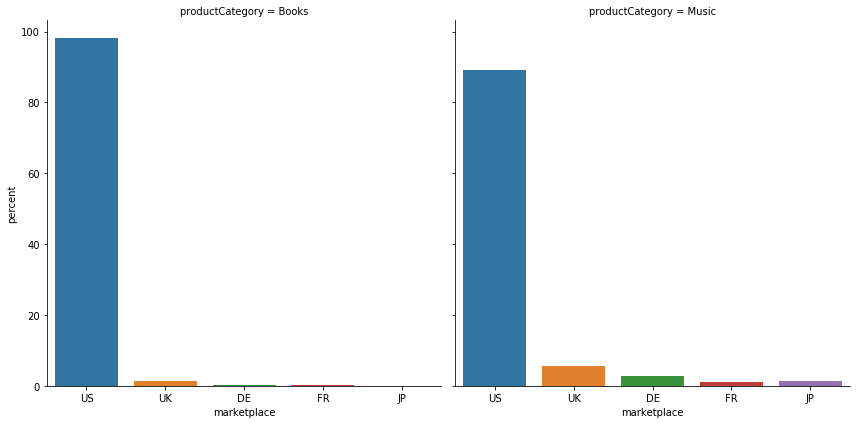

In [93]:

sns.catplot(
    data=df_reviews_by_marketplace_5.toPandas(), x="marketplace", y="percent", col="productCategory",
    kind="bar", height=6, aspect=1,
)

# Add labels and title
# Create a figure with a specified size

#plt.title('Number of 5-Star Ratings by Market Place')

Now, checking to see out of all the market places which Market place contributed most number of 1-star ratings

In [94]:
#filtering 5-star rating data
df_reviews_by_marketplace_1 = df_reviews_by_marketplace.filter(F.col('star_rating')==1)

In [95]:
df_reviews_by_marketplace_1 = df_reviews_by_marketplace_1.withColumn('percent',  F.col('count(review_id)')/F.sum('count(review_id)').over(Window.partitionBy('productCategory'))*100).sort(['productCategory', 'percent'], ascending =[True, False])

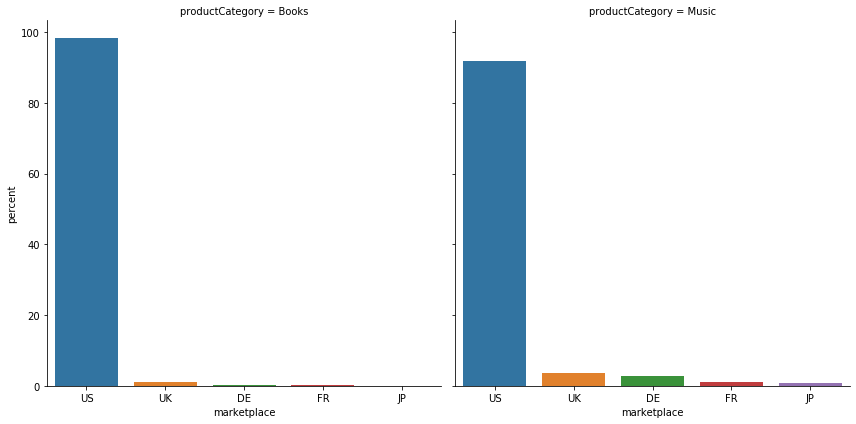

In [96]:

sns.catplot(
    data=df_reviews_by_marketplace_1.toPandas(), x="marketplace", y="percent", col="productCategory",
    kind="bar", height=6, aspect=1,
)

# Add labels and title
# Create a figure with a specified size

#plt.title('Number of 5-Star Ratings by Market Place')

The data seems to be skewed towards US market, as majority of the data is from the US marketplace.  

Therefore, now looking at each marketplace individually to see, out of all the reviews within a merketplace what is the proportion of various star-ratings

In [106]:
df_reviews_by_marketplace_mp = df_reviews_by_marketplace.withColumn('Total_Percent_by_mp_category',  F.round(F.col('count(review_id)')/F.sum('count(review_id)').over(Window.partitionBy('marketplace','productCategory'))*100,2)).sort(['marketplace', 'productCategory', 'Total_Percent_by_mp_category'], ascending=[True, True, False])

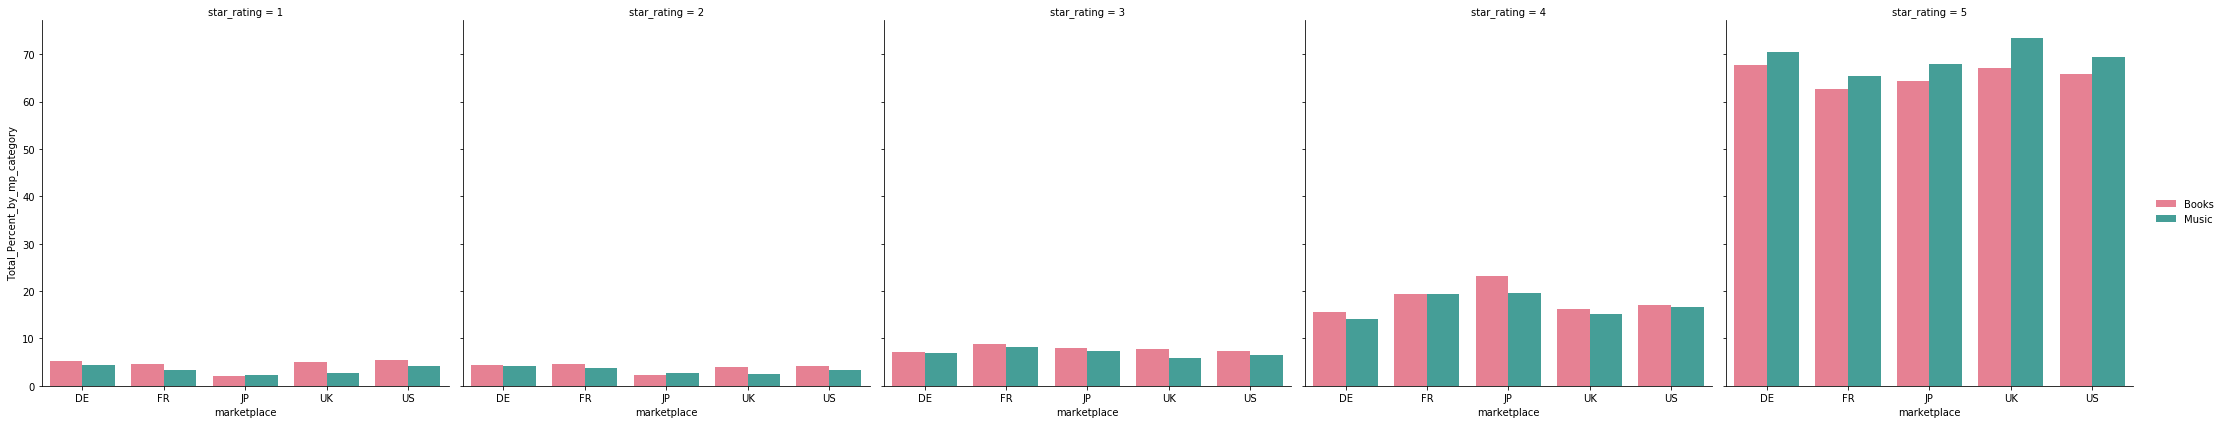

In [120]:
g = sns.FacetGrid(
    data=df_reviews_by_marketplace_mp.toPandas(), col="star_rating",
     height=6, aspect=1,
)



g.map_dataframe(sns.barplot, x="marketplace", y ='Total_Percent_by_mp_category', hue = 'productCategory', palette="husl")

g.add_legend()


It can be observed most of the 5-star reviews for music category are contributed by buyers in UK, whereas for books UK and DE make up for most of the 5-satr ratings. However, France seems to be getting least percent of 5-star rating in music and books categories

Looking at market places that had most amount of 1-star rating reviews ---> books products are getting more 1-star ratings than music products

#### 4. Looking at how helpful the reviews were across various categories 

In [137]:
#creating a datframe to calculate % of helpful reviews for each product category 
df_useful_reviews = df_music_books.groupby(['productCategory', 'star_rating']).agg(F.round((F.sum('helpful_votes')/F.sum('total_votes'))*100,2)).sort(['productCategory', 'star_rating'], ascending=[True, True])

In [138]:
df_useful_reviews.cache()

DataFrame[productCategory: string, star_rating: int, round(((sum(helpful_votes) / sum(total_votes)) * 100), 2): double]

In [140]:
df_useful_reviews = df_useful_reviews.select(F.col('productCategory'), F.col('star_rating'), F.round(F.col('round(((sum(helpful_votes) / sum(total_votes)) * 100), 2)')).alias('helpful_percent'))

In [141]:
df_useful_reviews.show()

+---------------+-----------+---------------+
|productCategory|star_rating|helpful_percent|
+---------------+-----------+---------------+
|          Books|          1|           49.0|
|          Books|          2|           62.0|
|          Books|          3|           69.0|
|          Books|          4|           80.0|
|          Books|          5|           82.0|
|          Music|          1|           33.0|
|          Music|          2|           42.0|
|          Music|          3|           54.0|
|          Music|          4|           76.0|
|          Music|          5|           80.0|
+---------------+-----------+---------------+



In [142]:
#converting to pandas
pd_useful_reviews = df_useful_reviews.toPandas()

In [ ]:
pd_useful_reviews.head()

In [143]:
df_heatmap = pd_useful_reviews.pivot( "star_rating", "productCategory","helpful_percent")

In [ ]:
df_heatmap.head()

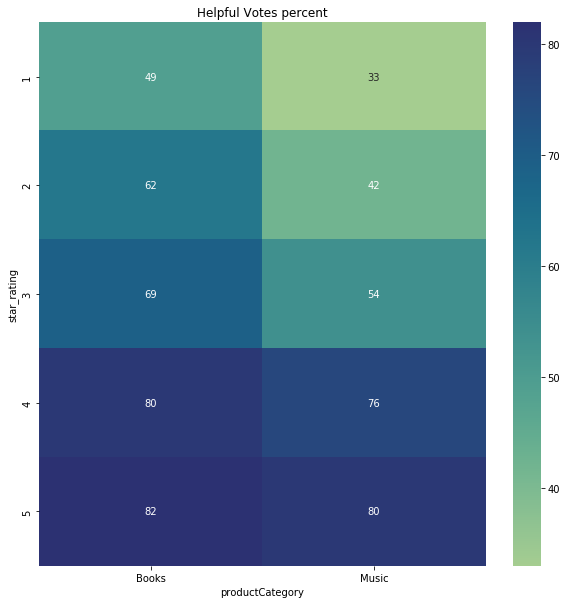

In [146]:
# Create a figure with a specified size
plt.figure(figsize=(10, 10))
# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Star Rating')
plt.title('Helpful Votes percent')
sns.heatmap(df_heatmap, annot = True, cmap="crest")

##### Based on the above graph the following can be observed: 
 - 5-Star rated reviews are considered helpful in both categories 
 - 1-Star rated reviews are found more helpful for books than for music category products 
 - As the rating drops, the percent of helpful votes also drops. 

#### 5. Helpful votes % across various categories by Marketplace

In [148]:
df_useful_reviews_mp = df_music_books.groupby(['marketplace','productCategory', 'star_rating']).agg(F.round((F.sum('helpful_votes')/F.sum('total_votes'))*100,2)).sort(['productCategory', 'star_rating'], ascending=[True, True, False])

In [149]:
df_useful_reviews_mp.show()

+-----------+---------------+-----------+---------------------------------------------------------+
|marketplace|productCategory|star_rating|round(((sum(helpful_votes) / sum(total_votes)) * 100), 2)|
+-----------+---------------+-----------+---------------------------------------------------------+
|         US|          Books|          1|                                                    48.54|
|         FR|          Books|          1|                                                     60.3|
|         UK|          Books|          1|                                                    51.17|
|         JP|          Books|          1|                                                    46.12|
|         DE|          Books|          1|                                                    40.49|
|         FR|          Books|          2|                                                    58.18|
|         JP|          Books|          2|                                                    44.81|


In [150]:
df_useful_reviews_mp = df_useful_reviews_mp.select(F.col('marketplace'), F.col('productCategory'), F.col('star_rating'), F.round(F.col('round(((sum(helpful_votes) / sum(total_votes)) * 100), 2)')).alias('helpful_percent'))

In [151]:
pd_useful_reviews_mp =  df_useful_reviews_mp.toPandas()

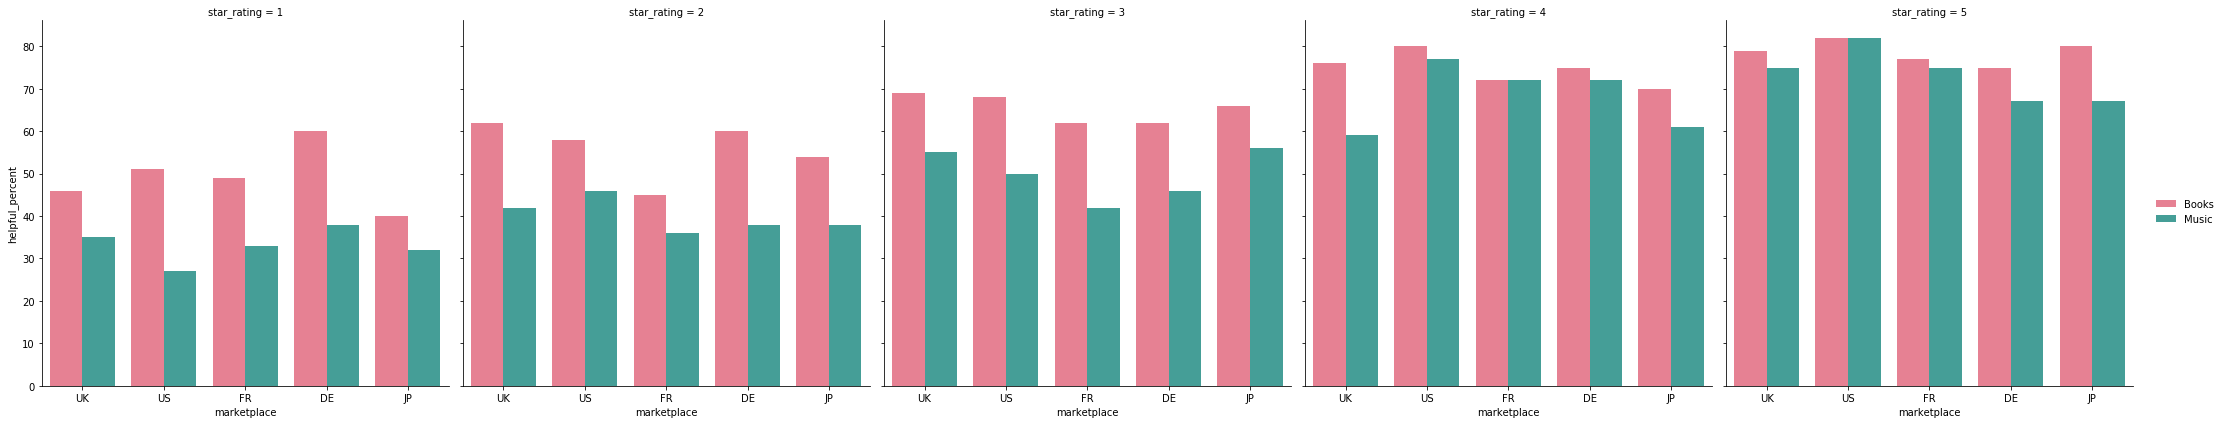

In [153]:
g = sns.FacetGrid(
    data=pd_useful_reviews_mp, col="star_rating", 
    height=6, aspect=1,
)


g.map_dataframe(sns.barplot, x="marketplace", y ='helpful_percent', hue = 'productCategory', palette="husl")

g.add_legend()







### 6. Avg length of reviews by product Category

In [156]:
df_length_reviews = df_music_books.groupby(['productCategory', 'star_rating']).agg((F.avg(F.length('review_body'))),F.round((F.sum('helpful_votes')/F.sum('total_votes'))*100,2)).sort(['productCategory', 'star_rating'], ascending=[True, True])

In [158]:
df_length_reviews = df_length_reviews.select('productCategory', 'star_rating', F.col('avg(length(review_body))').alias('avg_review_length'), F.col('round(((sum(helpful_votes) / sum(total_votes)) * 100), 2)').alias('helpful_percent'))

In [159]:
df_length_reviews.show()

+---------------+-----------+-----------------+---------------+
|productCategory|star_rating|avg_review_length|helpful_percent|
+---------------+-----------+-----------------+---------------+
|          Books|          1|781.7169655757765|          48.56|
|          Books|          2|914.8840249785927|          61.95|
|          Books|          3|937.4739585863945|           69.4|
|          Books|          4|894.2702509429536|          79.55|
|          Books|          5|592.9165767762097|          81.79|
|          Music|          1|558.8660788691647|           32.9|
|          Music|          2|740.2580634030198|          41.86|
|          Music|          3|829.7005252256251|           54.1|
|          Music|          4|843.9350968875281|          75.73|
|          Music|          5|580.5339100424954|          80.26|
+---------------+-----------+-----------------+---------------+



 From the above table it can be observed that shorter reviews are generally found to be more helpful across both the product categories

#### 7. Avg length of reviews by markept place and product Category

In [160]:
df_length_reviews_mp = df_music_books.groupby(['marketplace','productCategory', 'star_rating']).agg((F.avg(F.length('review_body')))).sort(['marketplace','productCategory', 'star_rating'], ascending=[True, True, False])

In [161]:
df_length_reviews_mp.show()

+-----------+---------------+-----------+------------------------+
|marketplace|productCategory|star_rating|avg(length(review_body))|
+-----------+---------------+-----------+------------------------+
|         DE|          Books|          5|       774.8532345793311|
|         DE|          Books|          4|       966.2710873727704|
|         DE|          Books|          3|      1079.5295154185021|
|         DE|          Books|          2|       972.0804800564772|
|         DE|          Books|          1|       844.5870794879428|
|         DE|          Music|          5|       826.9758661232861|
|         DE|          Music|          4|      1149.0931322690487|
|         DE|          Music|          3|      1133.8411712511092|
|         DE|          Music|          2|      1013.0656007172744|
|         DE|          Music|          1|       754.8204199855178|
|         FR|          Books|          5|       694.1774457329765|
|         FR|          Books|          4|       557.5910296599

In [162]:
pd_length_reviews_mp =  df_length_reviews_mp.toPandas()
pd_length_reviews_mp.head()

,marketplace,productCategory,star_rating,avg(length(review_body))
0,DE,Books,5,774.853235
1,DE,Books,4,966.271087
2,DE,Books,3,1079.529515
3,DE,Books,2,972.080480
4,DE,Books,1,844.587079


In [ ]:
g_MAP = sns.FacetGrid(
    data=pd_length_reviews_mp, col="productCategory", row="marketplace", 
    height=6, aspect=1,
)


g_MAP.map_dataframe(sns.barplot, x="star_rating", y ='avg(length(review_body))')




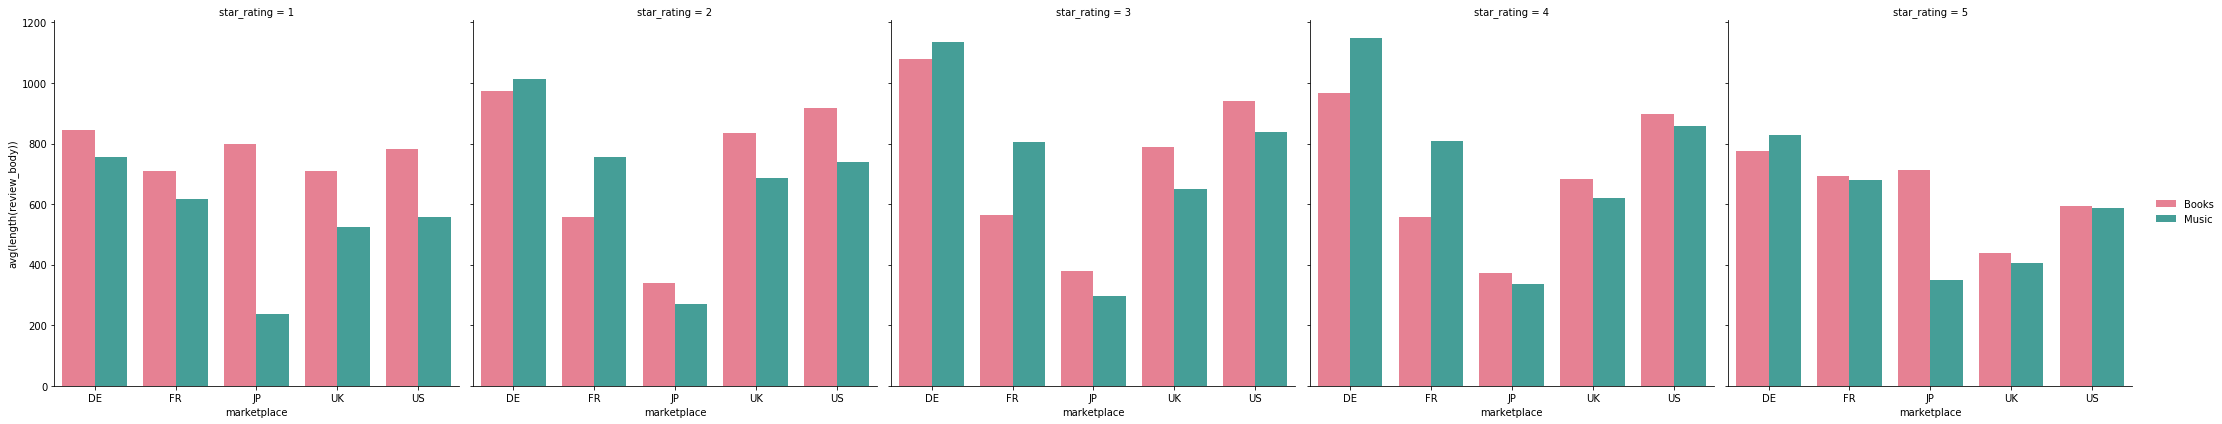

In [163]:
g = sns.FacetGrid(
    data=pd_length_reviews_mp, col="star_rating", 
    height=6, aspect=1,
)


g.map_dataframe(sns.barplot, x="marketplace", y ='avg(length(review_body))', hue = 'productCategory', palette="husl")

g.add_legend()
